# Hydrostatic equilibriation of models

Reimplementation of equilibration parts of the [corresponding example in JutulDarcy.jl](https://sintefmath.github.io/JutulDarcy.jl/dev/examples/workflow/equilibrium_state)



In [1]:
import jutuldarcy as jd
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Defining a reservior
Setting up a common reservoir (`DataDomain`) with two columns of 1000 vertical cells each to be used in the following examples.

In [2]:
nx = 2
nz = 1000
Darcy = jd.si_unit("darcy")
bar = jd.si_unit("bar")
yr = jd.si_unit("year")
meter = jd.si_unit("meter")
Kelvin = jd.si_unit("Kelvin")

cart_dims = (nx, 1, nz)
physical_dims = (20.0, 10.0, 1000.0)
g = jd.CartesianMesh(cart_dims, physical_dims)
# Convert to unstructured representation
g = jd.UnstructuredMesh(g)

# Shift the mesh so that the top of the mesh is at 800 m depth
for (i, pt) in enumerate(g.node_points):
    g.node_points[i] = pt + np.array([0.0, 0.0, 800.0])

reservoir = jd.reservoir_domain(g, porosity = 0.25, permeability = 0.1*Darcy)
ncells = jd.number_of_cells(reservoir)

reservoir

DataDomain wrapping UnstructuredMesh with 2000 cells, 2998 faces and 6004 boundary faces with 19 data fields added:
  2000 Jutul.Cells
    :permeability => 2000 Vector{Float64}
    :porosity => 2000 Vector{Float64}
    :rock_thermal_conductivity => 2000 Vector{Float64}
    :fluid_thermal_conductivity => 2000 Vector{Float64}
    :rock_heat_capacity => 2000 Vector{Float64}
    :component_heat_capacity => 2000 Vector{Float64}
    :rock_density => 2000 Vector{Float64}
    :cell_centroids => 3×2000 Matrix{Float64}
    :volumes => 2000 Vector{Float64}
  2998 Jutul.Faces
    :neighbors => 2×2998 Matrix{Int64}
    :areas => 2998 Vector{Float64}
    :normals => 3×2998 Matrix{Float64}
    :face_centroids => 3×2998 Matrix{Float64}
  5996 Jutul.HalfFaces
    :half_face_cells => 5996 Vector{Int64}
    :half_face_faces => 5996 Vector{Int64}
  6004 Jutul.BoundaryFaces
    :boundary_areas => 6004 Vector{Float64}
    :boundary_centroids => 3×6004 Matrix{Float64}
    :boundary_normals => 3×6004 Matrix{F

### Setup three-phase model with simple initial conditions

In [3]:
W = jd.AqueousPhase()
O = jd.LiquidPhase()
G = jd.VaporPhase()

rhoS = [1000.0, 700.0, 100.0]
sys_3ph = jd.ImmiscibleSystem((W, O, G), reference_densities = rhoS)
sys_3ph
density = jd.jl.ConstantCompressibilityDensities(sys_3ph, 1.5*bar, rhoS, 1e-5/bar)
model_3ph, prm_3ph = jd.setup_reservoir_model(reservoir, sys_3ph)
model_3ph = jd.set_secondary_variables(model_3ph, "Reservoir", PhaseMassDensities = density)

### Equilibriate single-region model

EquilibriumRegion is specified through a reference pressure at a given depth in the model.
We can also specify contact depths between phases

In [4]:
p_datum = 100*bar
datum_depth = 1000*meter
eq1 = jd.EquilibriumRegion(model_3ph, p_datum, datum_depth, 
                           woc = 1600.0*meter, goc = 1100.0*meter)
eq1


EquilibriumRegion{Float64} for 2000 cells with datum pressure 1.0e7 Pa at depth 1000.0 m
Water-Oil Contact: 1600.0 m, Gas-Oil Contact: 1100.0 m, Water-Gas Contact: NaN m


In [5]:
state0_3_ph_eql = jd.setup_reservoir_state(model_3ph, eq1)


Initialization: Rel. perm. is not a ReservoirRelativePermeabilities, skipping mobility check for reference pressure.


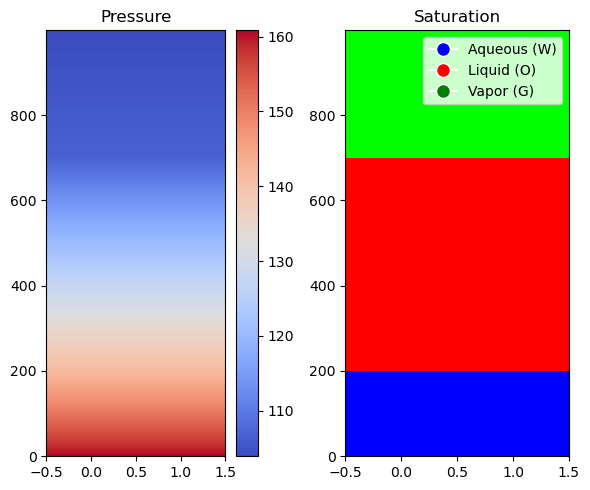

In [6]:
# Plotting
def plot_state0(state, phases='wog'):
    reservoir_d_jl = state[jd.jl.Symbol('Reservoir')]
    reservoir_d_py = jd.symdict_to_pydict(reservoir_d_jl)
    has_sat = 'Saturations' in reservoir_d_py
    has_comp = 'OverallMoleFractions' in reservoir_d_py
    
    # Define the figure size
    fig, axes = plt.subplots(1, 1 + has_sat + has_comp, figsize=((1 + has_sat + has_comp) * 3, 5))

    if has_sat + has_comp == 0:
        assert(not isinstance(axes, list))
        axes = [axes]
    
    def to_mesh(x):
        return x.reshape(nz, nx)[::-1,:]

    def colors_to_mesh(x):
        return x.reshape((nz, nx, 3))[::-1, :, :]
    
    # Plot Pressure
    ax1 = axes[0]
    ax1.set_title("Pressure")
    p = np.divide(reservoir_d_py['Pressure'], bar)
    meshed_p = to_mesh(p)
    plt_pres = ax1.imshow(to_mesh(p), cmap='coolwarm', aspect='auto', origin='lower', interpolation='None' )
    fig.colorbar(plt_pres, ax=ax1)
    
    if has_sat:
        sat = reservoir_d_py['Saturations']
        count = 0
        def to_rgb(i):
            # count += 1
            if phases == 'wog':
                return (sat[1, i], sat[2, i], sat[0, i])
            elif phases == 'og':
                return (sat[0, i], sat[1, i], 0.0)
            elif phases == 'wg':
                return (0.0, sat[1, i], sat[0, i])
        
        sat_rgb = np.array([to_rgb(i) for i in range(sat.shape[1])])
        meshed_sat_rgb = colors_to_mesh(sat_rgb)
        ax2 = axes[1]
        ax2.set_title("Saturation")
        plt_sat = ax2.imshow(meshed_sat_rgb, cmap='coolwarm', aspect='auto', origin='lower', interpolation='None')
        
        # Custom legend
        e_wat = plt.Line2D([0], [0], marker='o', color='w', label='Aqueous (W)',
                           markerfacecolor='b', markersize=10)
        e_oil = plt.Line2D([0], [0], marker='o', color='w', label='Liquid (O)',
                           markerfacecolor='r', markersize=10)
        e_gas = plt.Line2D([0], [0], marker='o', color='w', label='Vapor (G)',
                           markerfacecolor='g', markersize=10)
        ax2.legend(handles=[e_wat, e_oil, e_gas], loc='upper right')
        
        if has_comp:
            comp = reservoir_d_py['OverallMoleFractions']
            ax3 = axes[2]
            ax3.set_title("Mole fraction, component 1")
            plt_comp = ax3.imshow(to_mesh(comp[0, :]), vmin=0.0, vmax=1.0)  
            fig.colorbar(plt_comp, ax=ax3)
    
    plt.tight_layout()
    plt.show()

plot_state0(state0_3_ph_eql)


# Test two region system

Initialization: Rel. perm. is not a ReservoirRelativePermeabilities, skipping mobility check for reference pressure.
Initialization: Rel. perm. is not a ReservoirRelativePermeabilities, skipping mobility check for reference pressure.


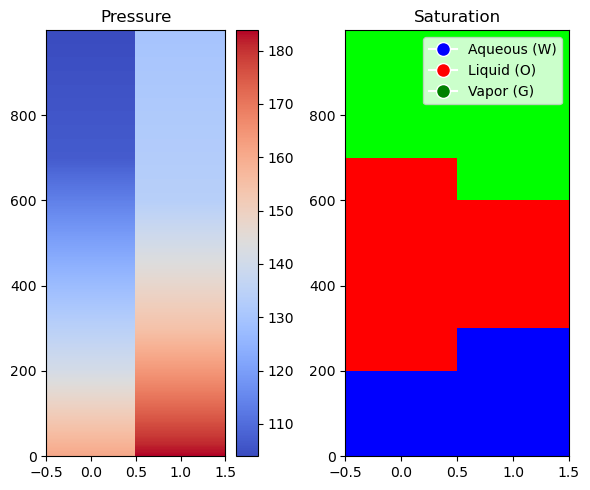

In [7]:
region_A = np.arange(0, 2000, 2)+1
region_B = np.arange(1, 2000, 2)+1

eql_A = jd.EquilibriumRegion(model_3ph, 100*bar, 1000*meter, woc = 1600.0, goc= 1100.0, cells=region_A)
eql_B = jd.EquilibriumRegion(model_3ph, 120*bar, 1000*meter, woc = 1500.0, goc= 1200.0, cells=region_B)

state0_two_reg = jd.setup_reservoir_state(model_3ph, jd.jl.Vector([eql_A, eql_B]))
plot_state0(state0_two_reg)

#### Using the black-oil model with capillary pressure
Using the SPE9 fluid system in our 2 x 1000 reservior model

In [8]:
spe9_path = jd.test_file_path("SPE9", "SPE9.DATA")
spe9_case = jd.setup_case_from_data_file(spe9_path)
model_bo, _ = jd.setup_reservoir_model(reservoir, spe9_case.model)



PVT: Fixing table for low pressure conditions.


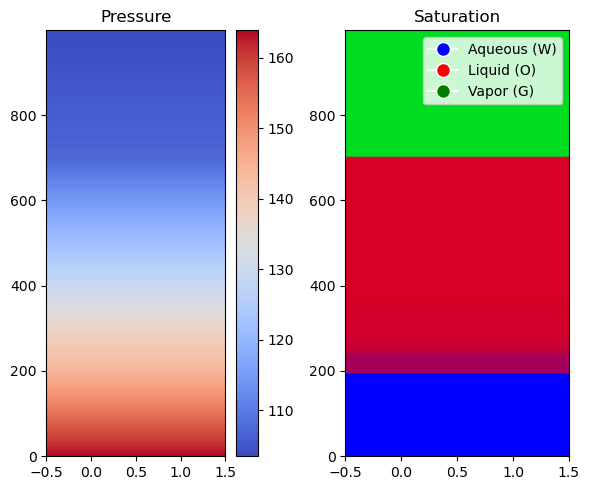

Initialization: Negative saturation in 592 cells for phase 2. Normalizing.


In [9]:
eql_bo = jd.EquilibriumRegion(model_bo, 100*bar, 1000*meter, woc = 1600.0, goc= 1100.0, rs= 15.0)
state0_bo = jd.setup_reservoir_state(model_bo, eql_bo)
plot_state0(state0_bo)

In [10]:
model_bo[jd.jl.Symbol('Reservoir')].secondary_variables

OrderedCollections.OrderedDict{Symbol, Any} with 12 entries:
  :TotalMasses             => TotalMasses()
  :RelativePermeabilities  => ReservoirRelativePermeabilities{NoKrScale, :wog, …
  :PhaseMobilities         => PhaseMobilities()
  :Saturations             => Saturations(0.2)
  :PhaseState              => BlackOilPhaseState()
  :SurfaceVolumeMobilities => SurfaceVolumeMobilities()
  :Rs                      => Rs{Tuple{LinearInterpolant{Vector{Float64}, Vecto…
  :ShrinkageFactors        => DeckShrinkageFactors{Tuple{PVTW{1, ConstMuBTable{…
  :PhaseViscosities        => DeckPhaseViscosities{Tuple{PVTW{1, ConstMuBTable{…
  :PhaseMassDensities      => DeckPhaseMassDensities{Tuple{PVTW{1, ConstMuBTabl…
  :CapillaryPressure       => SimpleCapillaryPressure{Tuple{Tuple{LinearInterpo…
  :FluidVolume             => LinearlyCompressiblePoreVolume{Tuple{Float64}, Ve…

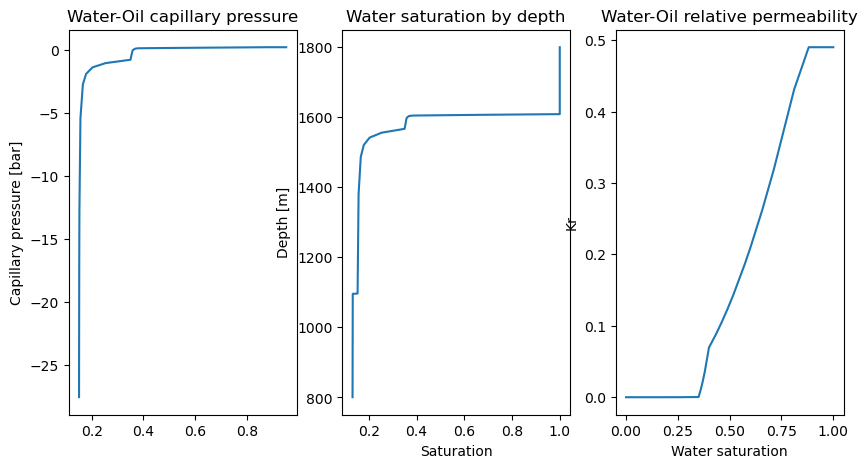

In [11]:

reservoir_bo_sv_d_jl = model_bo[jd.jl.Symbol('Reservoir')].secondary_variables
#reservoir_bo_d_jl[jd.jl.Symbol('CapillaryPressure')]
reservoir_bo_sv_d_py = jd.symdict_to_pydict(reservoir_bo_sv_d_jl)
pc = reservoir_bo_sv_d_py['CapillaryPressure'].pc[0][0]
krw = reservoir_bo_sv_d_py['RelativePermeabilities'].krw[0]
# sw = reservoir_d_py['Saturations'][0, :]
sw = state0_bo[jd.jl.Symbol('Reservoir')][jd.jl.Symbol('Saturations')][0,:]

# Create a figure with a specific size
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Plot Water-Oil capillary pressure
ax1.set_title("Water-Oil capillary pressure")
ax1.set_ylabel("Capillary pressure [bar]")
ax1.plot(pc.X, np.divide(pc.F, bar))

# Plot Water saturation by depth
ax2.set_title("Water saturation by depth")
ax2.set_ylabel("Depth [m]")
ax2.set_xlabel("Saturation")
ax2.plot(sw, reservoir[jd.jl.Symbol('cell_centroids')][2, :])

# Plot Water-Oil relative permeability
ax3.set_title("Water-Oil relative permeability")
ax3.set_ylabel("Kr")
ax3.set_xlabel("Water saturation")
ax3.plot(krw.k.X, krw.k.F)



## Compositional model

In [12]:
# Depends on MultiComponentFlash.jl, skipping for now

## Single-phase water model

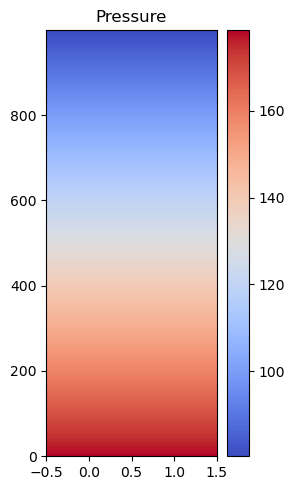

setup_reservoir_state: Recieved primary variable Saturations, but this is not known to reservoir model.


In [13]:
sys_1ph = jd.SinglePhaseSystem(reference_density = 1000.0)
model_1ph, _ = jd.setup_reservoir_model(reservoir, sys_1ph)
eql_1ph = jd.EquilibriumRegion(model_1ph, 100*bar, 1000*meter)
state0_1ph = jd.setup_reservoir_state(model_1ph, eql_1ph)
plot_state0(state0_1ph)

## Two-phase water gas

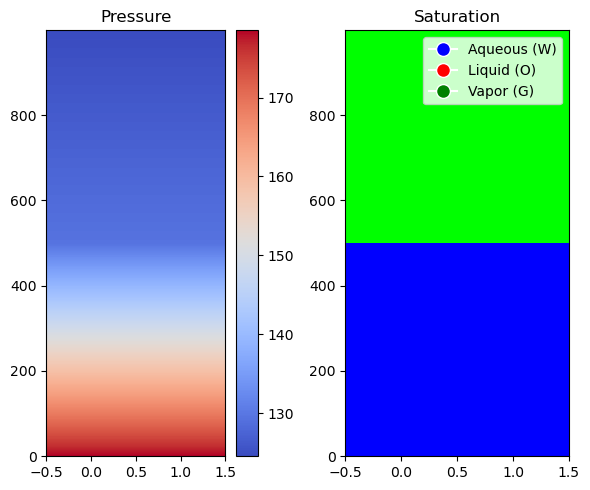

Initialization: Rel. perm. is not a ReservoirRelativePermeabilities, skipping mobility check for reference pressure.


In [14]:
reload(jd.model)
reload(jd)

rhoS = [1000.0, 100.0]
sys_wg = jd.ImmiscibleSystem((W, G), reference_densities = rhoS)
rho = jd.ConstantCompressibilityDensities(sys_wg, 1.5*bar, rhoS, np.divide(1e-5,bar))
model_wg, prm_wg = jd.setup_reservoir_model(reservoir, sys_wg)

model_wg = jd.set_secondary_variables(model_wg, "Reservoir", PhaseMassDensities = rho)

eql_wg = jd.EquilibriumRegion(model_wg, 100*bar, 1000*meter, wgc=1300.0*meter)
state0_wg = jd.setup_reservoir_state(model_wg, eql_wg)
plot_state0(state0_wg, phases='wg')